In [155]:
import numpy as np
from newsapi.newsapi_client import NewsApiClient
import matplotlib.pyplot as plt
import json
import random
from datetime import date, timedelta, datetime
import seaborn
import time
import pandas
import re
from dataset import *
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import spacy

In [156]:
dji_data = pandas.read_csv('data/DJI.csv')

In [161]:
api_key = 'b55d5b6ac298484aa95f84703500cd93'

# e9436ecde682495cb27258cf59eefcb0

# 680c1b180ccb466091542bdaef7f5b79

newsapi = NewsApiClient(api_key=api_key)

In [158]:
def aspect_level_format(training_text):
    nlp = spacy.load('en_core_web_sm')
    training_text = map(lambda x:x.lower(),training_text)
    sentiment_terms = []
    for text in nlp.pipe(training_text):
            if text.is_parsed:
                sentiment_terms.append(' '.join([token.lemma_ for token in text if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
            else:
                sentiment_terms.append('')
    return sentiment_terms

def create_tokenizer():
    training_text, _, _, _ = create_dataset()
    #level_text = aspect_level_format(training_text)
    tokenizer = Tokenizer(num_words=50000)
    tokenizer.fit_on_texts(training_text)
    return tokenizer

tokenizer = create_tokenizer()
loaded_model = load_model('models/cnn_sentence_level_fast_text.h5')

In [159]:
def get_article(query, source, date):
    api_response = newsapi.get_everything(q=query,
                                      sources=source,
                                      from_param=date,
                                      to=date,
                                      language='en',
                                      sort_by='relevancy',
                                      page=1)
    articles = api_response['articles']
    num_articles = len(articles) > 0
    assert num_articles > 0
    return [articles[0]]

def preprocess_text(text):
    TAG_RE = re.compile(r'<[^>]+>')

    text = TAG_RE.sub('', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()

    return text

def get_sentiment_prediction(sentence):
    sentence = [preprocess_text(sentence)]
    sentence = tokenizer.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, padding='post', maxlen=30)
    prediction = loaded_model.predict_classes(sentence)[0][0]
    return prediction

In [162]:
article = get_article('U.S. economy', 'reuters', '2020-03-23')

print(article)
print(get_sentiment_prediction(article[0]['description']))

[{'source': {'id': 'reuters', 'name': 'Reuters'}, 'author': 'Reuters Editorial', 'title': 'Fed mounts aggressive new steps to combat coronavirus hit to economy', 'description': 'The U.S. Federal Reserve on Monday said it would begin backstopping an unprecedented range of credit for households, small businesses and major employers in an effort to offset the "severe disruptions" to the economy caused by the coronarvirus outbreak.', 'url': 'https://www.reuters.com/article/us-health-coronavirus-usa-fed-idUSKBN21A1U2', 'urlToImage': 'https://s4.reutersmedia.net/resources/r/?m=02&d=20200323&t=2&i=1507060250&w=1200&r=LYNXMPEG2M13S', 'publishedAt': '2020-03-23T12:28:00Z', 'content': '(Reuters) - The U.S. Federal Reserve on Monday said it would begin backstopping an unprecedented range of credit for households, small businesses and major employers in an effort to offset the “severe disruptions” to the economy caused by the coronarvirus out… [+788 chars]'}]
0


In [163]:
def create_graph(query, source, from_date, to_date):
    current_date = datetime.strptime(from_date, '%Y-%m-%d').date()
    end_date = datetime.strptime(to_date, '%Y-%m-%d').date()
    dates = []
    sentiment = []
    dji_values = []
    
    while current_date <= end_date:
        close_value = dji_data.loc[dji_data['Date'] == str(current_date)]['Close']
        
        if len(close_value) > 0:
            dji_values.append(float(close_value))
        else:
            dji_values.append(dji_values[-1])
        
        articles = get_article(query, source, str(current_date))
        dates.append(current_date)
        
        pos_counter = 0
        
        for article in articles:
            if get_sentiment_prediction(article['description']) == 1:
                pos_counter += 1
        
        ratio = pos_counter / len(articles)
        
        if ratio >= 0.5:
            sentiment.append(1)
        else:
            sentiment.append(0)
        
        current_date += timedelta(1)
        
    plt.plot(dates, dji_values)
    plt.gcf().autofmt_xdate()
    
    for i in range(len(sentiment)):
        if sentiment[i] == 1:
             plt.axvline(pandas.Timestamp(str(dates[i])), color='g', linewidth=9, alpha=0.1)
        else:
             plt.axvline(pandas.Timestamp(str(dates[i])), color='r', linewidth=9, alpha=0.1)
    
    plt.show()

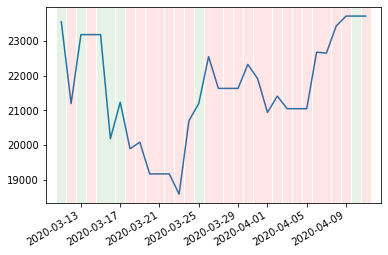

In [164]:
create_graph('U.S. economy', 'reuters', '2020-03-11', '2020-04-11')

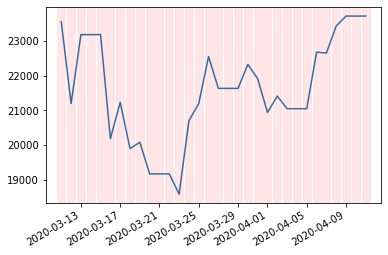

In [165]:
create_graph('U.S. economy', 'usa-today', '2020-03-11', '2020-04-11')

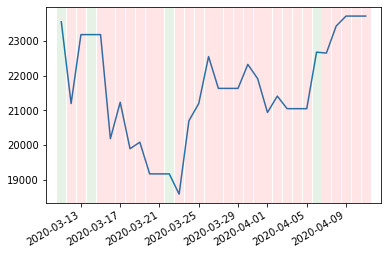

In [166]:
create_graph('United States economy', 'fox-news', '2020-03-11', '2020-04-11')

In [151]:
create_graph('United States economy', 'cnn', '2020-03-11', '2020-04-11')

AssertionError: 